<h2><center> Ultimate Data Science Challenge: Solution</center></h2>
<h4><center>By: Lauren Broussard</center></h4>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

import seaborn as sns
import matplotlib.dates as dates

%matplotlib inline
sns.set()

### Part 1 ‑ Exploratory data analysis
Instructions: *The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15-minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.*

----

#### Import and Inspect File

In [2]:
logins='logins.json'

# create dataframe from json file
df = pd.read_json(logins, convert_dates=True)
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None
                 login_time
count                 93142
unique                92265
top     1970-02-12 11:16:53
freq                      3
first   1970-01-01 20:12:16
last    1970-04-13 18:57:38


With a quick look at the range of dates in the data, we can see that these are all rides from between February 12, 1970 and April 13, 1970. In that two month period, there were 93,142 rides. 

#### Aggregate Rides (15 Minute Increments)

We will downsample our data with the resample() method to get our data aggregated over 15 minute intervals. 

In [4]:
# resample login times for every fifteen minutes 
df = df.resample('15min',on='login_time').count().rename(columns={'login_time':'count'})
df.reset_index(inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9788 entries, 0 to 9787
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  9788 non-null   datetime64[ns]
 1   count       9788 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 153.1 KB


In [6]:
df['month'] = df.login_time.dt.month
df['day'] = df.login_time.dt.day
df['day_of_week'] = df.login_time.dt.dayofweek
df['week'] = df.login_time.dt.week
df['hour'] = df.login_time.dt.hour
df['minute'] = df.login_time.dt.minute
new_dates, new_times = zip(*[(d.date(), d.time()) for d in df['login_time']])
df = df.assign(new_date=new_dates, new_time=new_times)

df.head()

,login_time,count,month,day,day_of_week,week,hour,minute,new_date,new_time
0,1970-01-01 20:00:00,2,1,1,3,1,20,0,1970-01-01,20:00:00
1,1970-01-01 20:15:00,6,1,1,3,1,20,15,1970-01-01,20:15:00
2,1970-01-01 20:30:00,9,1,1,3,1,20,30,1970-01-01,20:30:00
3,1970-01-01 20:45:00,7,1,1,3,1,20,45,1970-01-01,20:45:00
4,1970-01-01 21:00:00,1,1,1,3,1,21,0,1970-01-01,21:00:00


#### Visualize

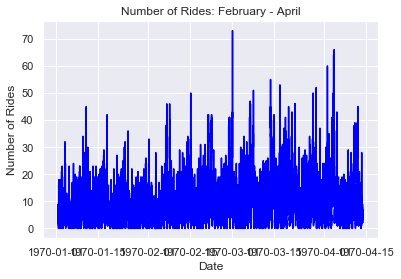

In [7]:
_ = plt.plot(df.login_time, df['count'],color='blue')
_ = plt.title('Number of Rides: February - April')
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of Rides')
plt.rcParams['figure.figsize'] = 20,10

There appears to be a cyclical nature to the daily rides - with definite low points and definite high points. let's look further into the average rides during a 24 hour time period to look further at the fluctuation. 

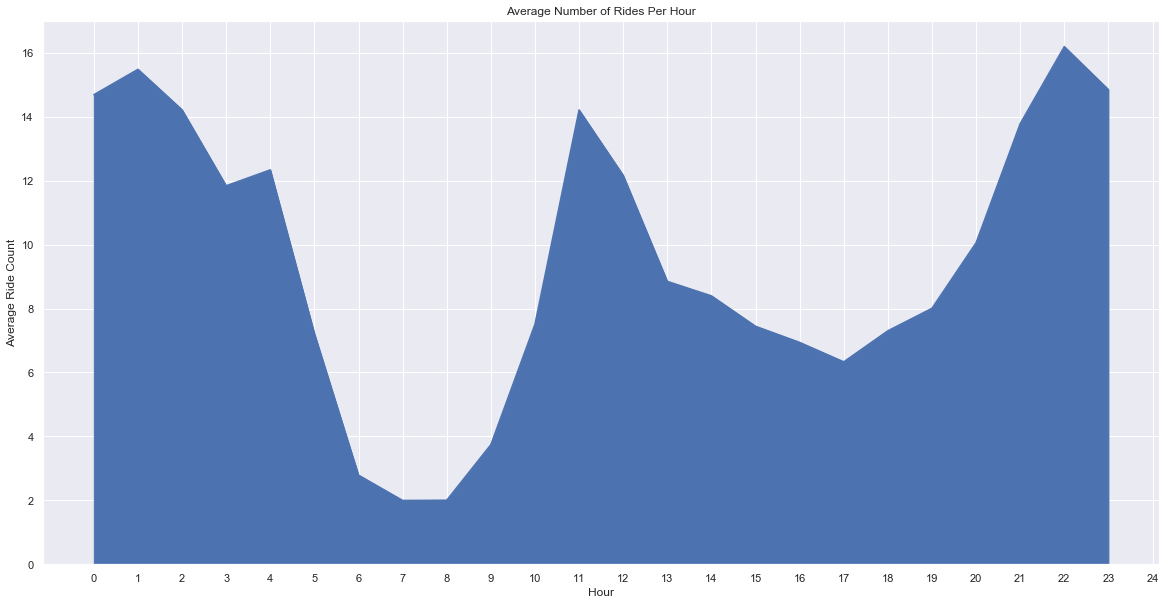

In [8]:
_ = df.groupby('hour')['count'].mean().plot(kind='area')
_ = plt.title('Average Number of Rides Per Hour')
_ = plt.xlabel('Hour')
_ = plt.ylabel('Average Ride Count')
_ = plt.xticks(np.arange(0,25))
plt.rcParams['figure.figsize'] = 20,10

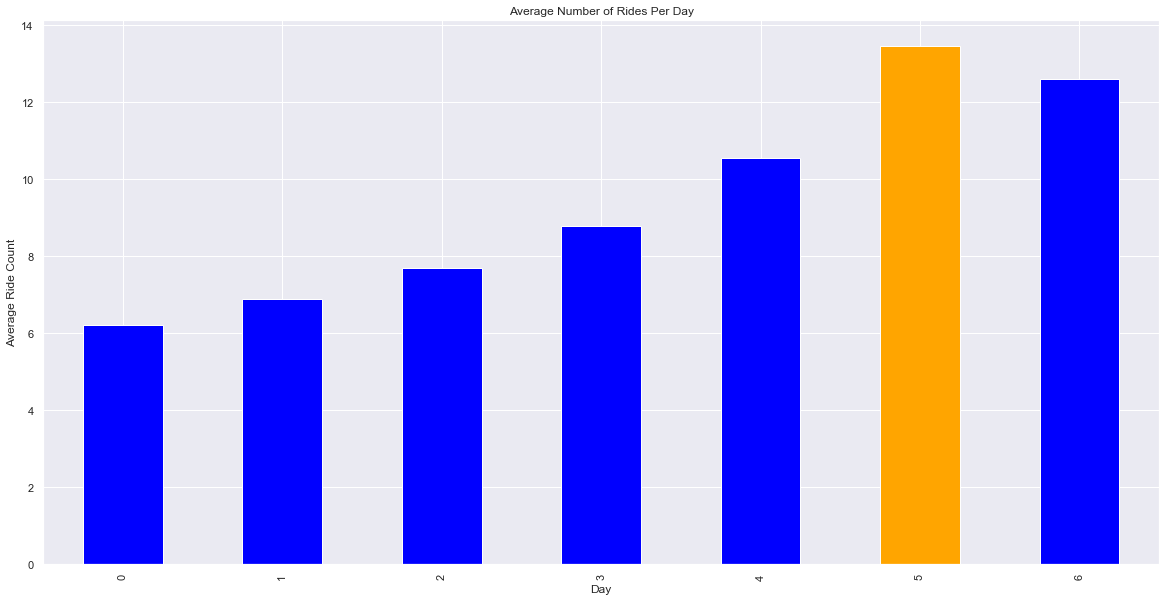

In [9]:
colors = ['blue','blue','blue','blue','blue','orange','blue','blue']
_ = df.groupby('day_of_week')['count'].mean().plot(kind='bar', color = colors)
_ = plt.title('Average Number of Rides Per Day')
_ = plt.xlabel('Day')
_ = plt.ylabel('Average Ride Count')

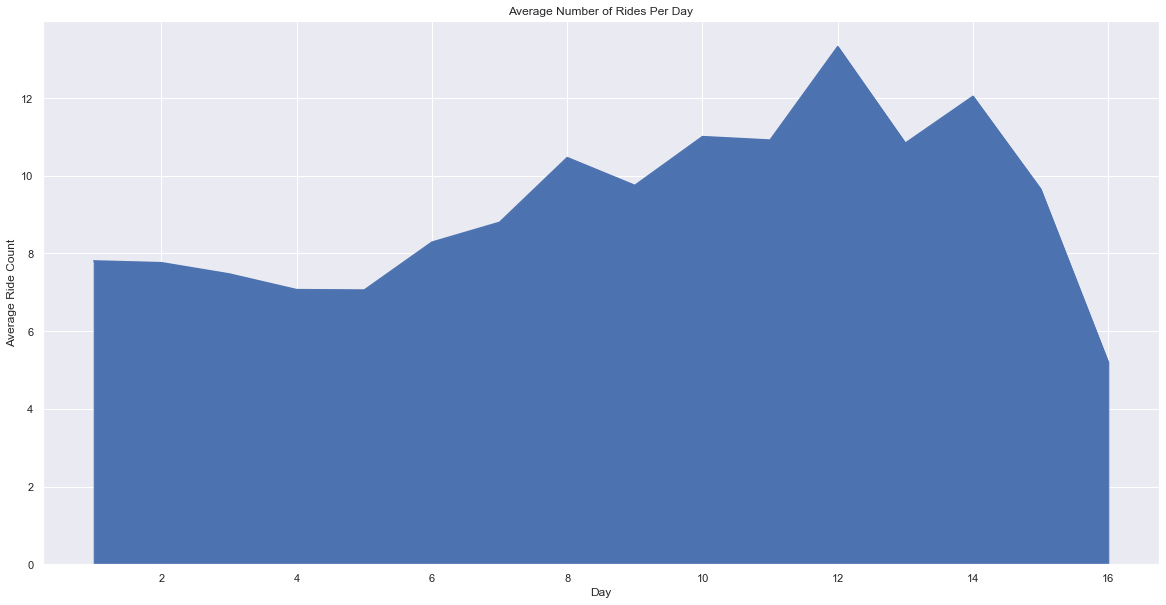

In [10]:
_ = df.groupby('week')['count'].mean().plot(kind='area')
_ = plt.title('Average Number of Rides Per Day')
_ = plt.xlabel('Day')
_ = plt.ylabel('Average Ride Count')

In [11]:
df.groupby('day_of_week')['count'].mean()

day_of_week
0     6.213380
1     6.895833
2     7.692708
3     8.794118
4    10.561111
5    13.456250
6    12.615972
Name: count, dtype: float64

----

### Part 3 ‑ Predictive Modeling (Predicting User Retention) 
Instructions: *Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days. We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.*

#### Import and Inspect File

In [12]:
users ='ultimate_data_challenge.json'

# create dataframe from json file
users_df = pd.read_json(users, convert_dates=['signup_date','last_trip_date'])
users_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [13]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

#### Label "Retained" Users

In [14]:
# find max date
users_df.last_trip_date.describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

The most recent trip was taken July 1, 2014. To find active users then, we will count 30 days prior to July 1. Therefore, any user who took a between June 1 and July 1 will be counted as "Retained."

In [15]:
import datetime as dt

# label retained users
users_df['retained'] = users_df['last_trip_date'].dt.month.apply(lambda x: 1 if x >= 6 else 0)

In [16]:
num_retained = users_df.retained.sum()
print("There are {} retained users.".format(num_retained))
print("This is {}% of the user population.".format(round(num_retained/len(users_df)*100,2)))

There are 18804 retained users.
This is 37.61% of the user population.


There are 18804 'retained' users. 

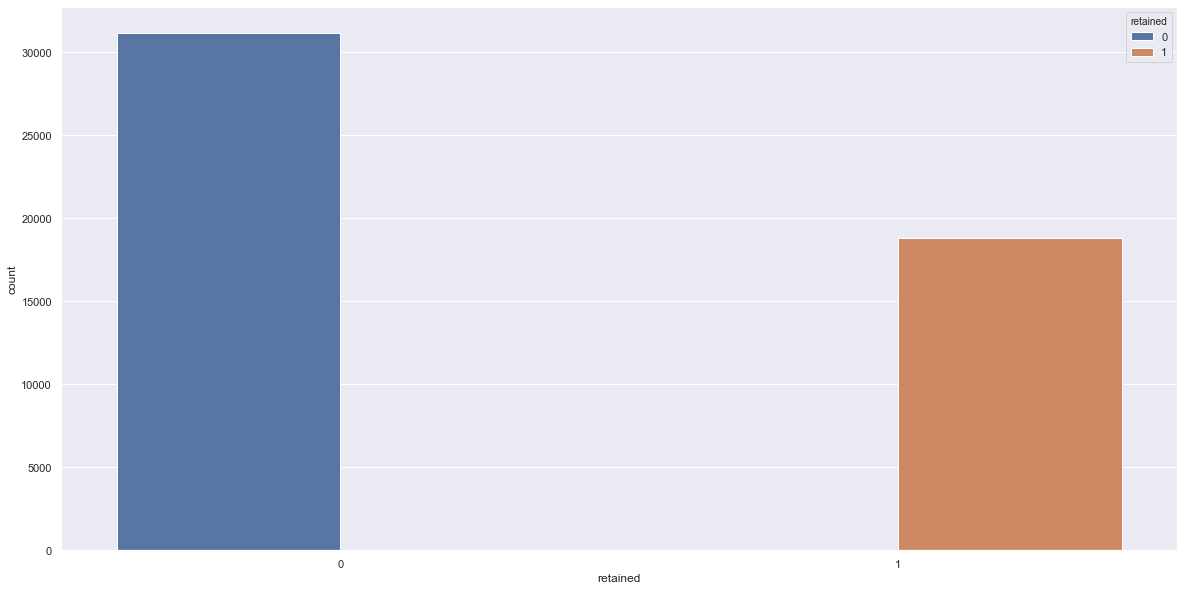

In [154]:
sns.countplot(x='retained',hue='retained',data=users_df)

#### Data Cleaning 

Two fields with missing values are the fields "avg_rating_by_driver" and "avg_rating_of_driver." We'll fill both of these with the mean for each. 

In [17]:
# mean driver rating
print('Average Rating OF Driver:', users_df.avg_rating_of_driver.mean())
print('Average Rating BY Driver:', users_df.avg_rating_by_driver.mean())

# fill in avg_rating_of_driver with mean (or median)
users_df.avg_rating_of_driver.fillna(users_df.avg_rating_of_driver.mean(),inplace=True)

# fill in avg_rating_by driver with mean (or median)
users_df.avg_rating_by_driver.fillna(users_df.avg_rating_by_driver.mean(),inplace=True)

Average Rating OF Driver: 4.6015592912744685
Average Rating BY Driver: 4.778158195947439


There are 396 missing values for Phone type. Since we are not sure which phone the user signed up with, we will fill the missing values with the word "Other."

In [18]:
# fill missing phone with "Other"
users_df.phone.fillna('Other',inplace=True)

Next, we'll look for duplicates. 

In [19]:
# look for duplicates
users_df[users_df.duplicated()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
2608,Astapor,1,2014-01-18,5.000000,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0,0
18057,Astapor,1,2014-01-11,5.000000,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0,0
29601,Winterfell,1,2014-01-01,4.601559,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0,0
34641,Winterfell,1,2014-01-18,4.601559,1.0,2014-01-19,iPhone,0.0,True,0.0,1.44,5.0,0
36627,Winterfell,1,2014-01-18,5.000000,1.0,2014-01-19,Android,0.0,False,0.0,3.54,5.0,0
39601,Winterfell,1,2014-01-10,5.000000,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0,0
42025,Winterfell,1,2014-01-18,4.601559,1.0,2014-01-19,Android,0.0,False,0.0,0.01,5.0,0
45416,Astapor,1,2014-01-20,5.000000,1.0,2014-01-20,iPhone,0.0,False,100.0,3.06,5.0,0


Without much more data (for instance, the rider's last name or email), it is difficult to see whether or not these 8 records are true duplicates. For that reason, we will keep them in the dataset. 

Finally, we'll look for potential outliers in the data. 

In [20]:
users_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.376080
std,3.792684,0.564977,0.222336,19.958811,37.081503,5.707357,0.445753,0.484405
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000


#### EDA

Let's use a boxplot to look at the overall distribution for the features. 

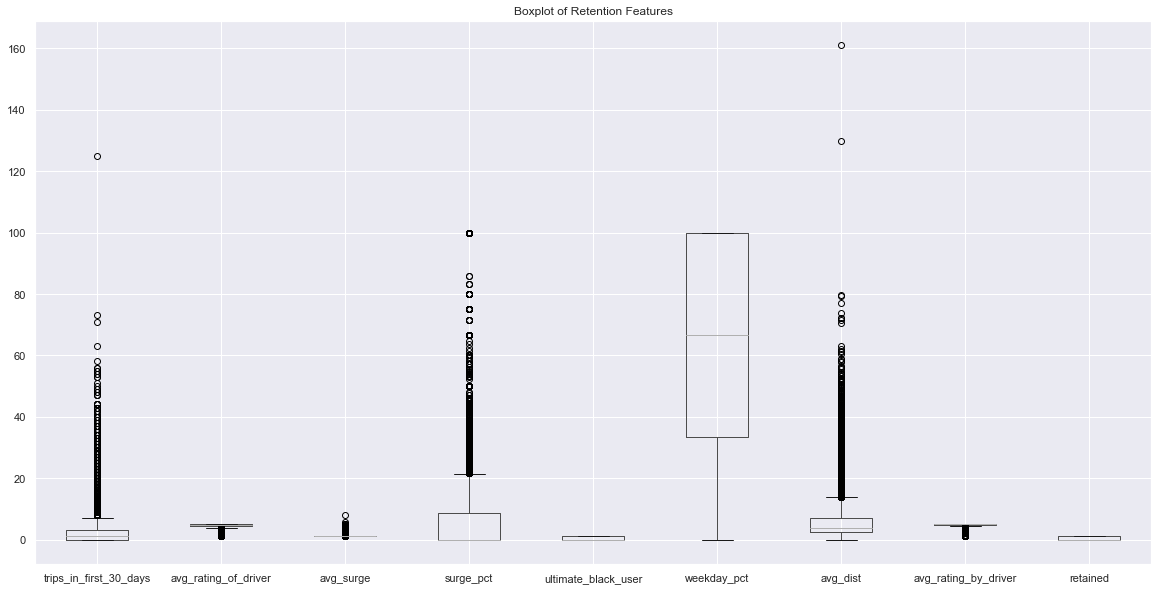

In [21]:
_ = users_df.boxplot()
_ = plt.title('Boxplot of Retention Features')

In [22]:
# drop trips_in_first_30_days outlier
users_df.drop(users_df[users_df['trips_in_first_30_days'] > 120].index,axis=0,inplace=True)

In [23]:
# drop 2 avg_dist outliers 
users_df.drop(users_df[users_df['avg_dist'] > 120].index,axis=0,inplace=True)

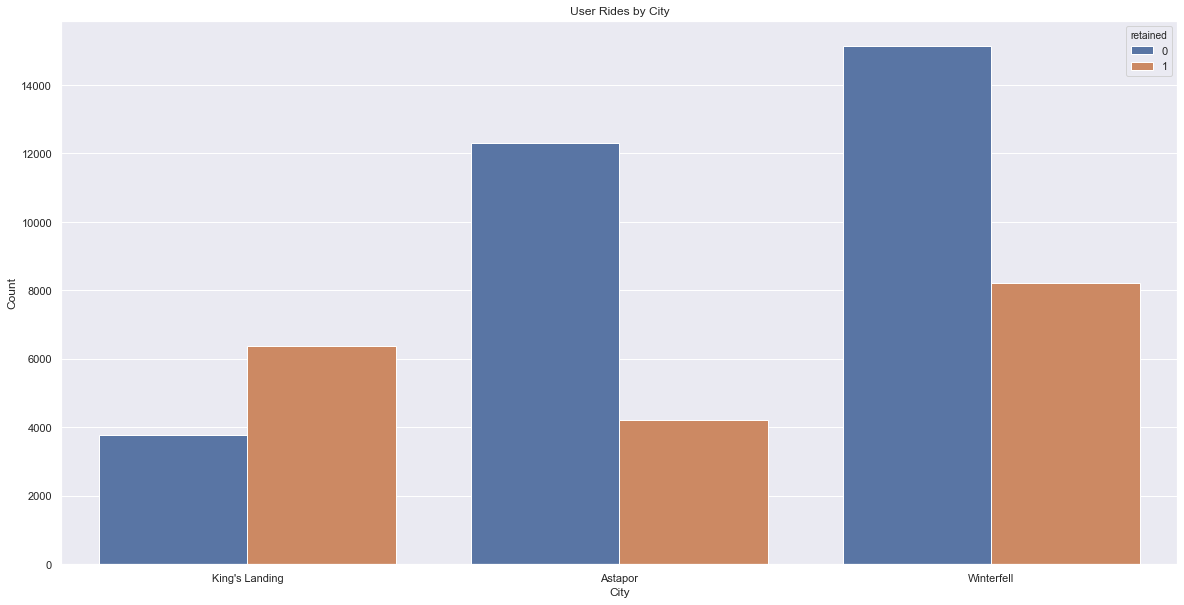

In [24]:
_ = sns.countplot(x='city',hue='retained',data=users_df)
_ = plt.title('User Rides by City')
_ = plt.xlabel('City')
_ = plt.ylabel('Count')

When looking at the city, it appears that one city, King's Landing, has a higher number of retained users than the other two cities. This may be worth looking at further. 

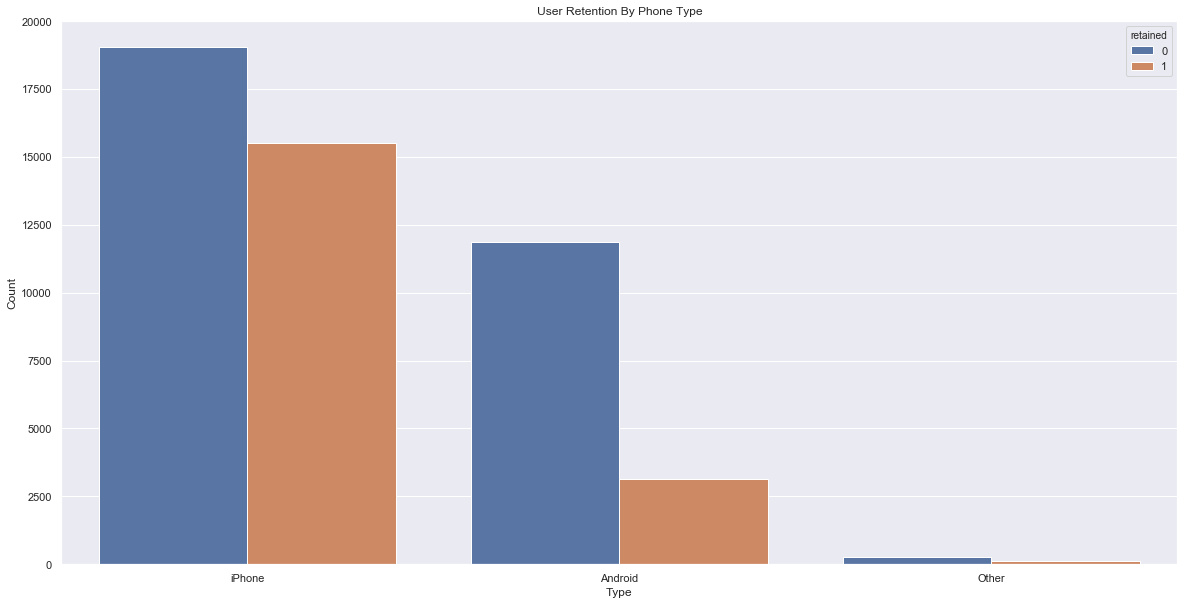

In [25]:
_ = sns.countplot(x='phone',hue='retained',data=users_df)
_ = plt.title('User Retention By Phone Type')
_ = plt.xlabel('Type')
_ = plt.ylabel('Count')

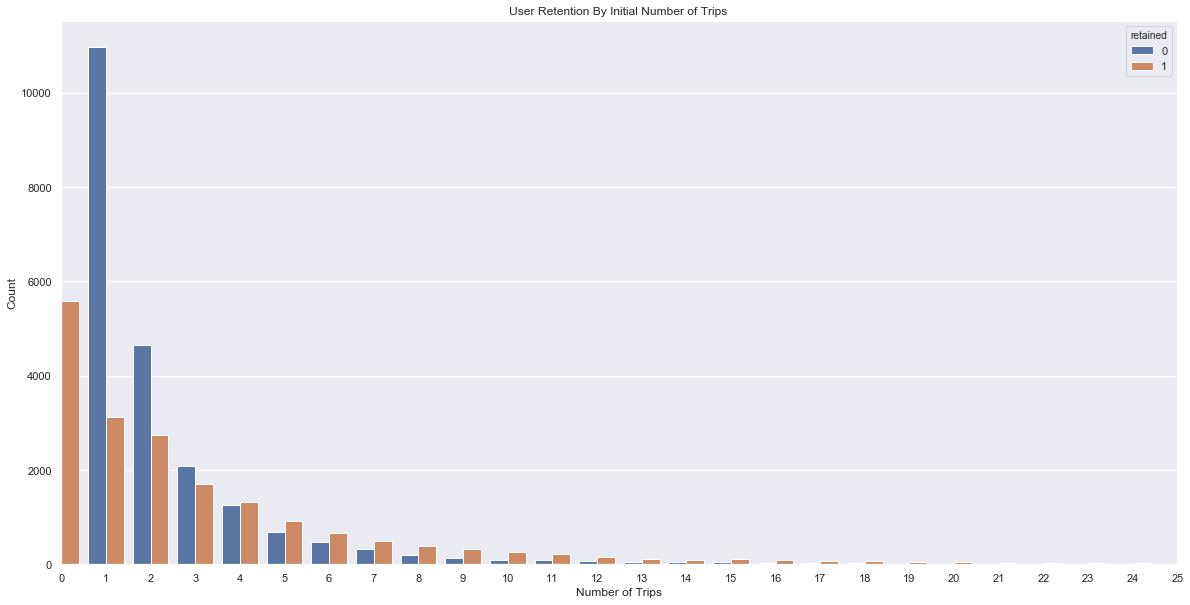

In [199]:
_ = sns.countplot(x='trips_in_first_30_days',hue='retained',data=users_df)
_ = plt.title('User Retention By Initial Number of Trips ')
_ = plt.xlabel('Number of Trips')
_ = plt.ylabel('Count')
_ = plt.xlim(0,25)

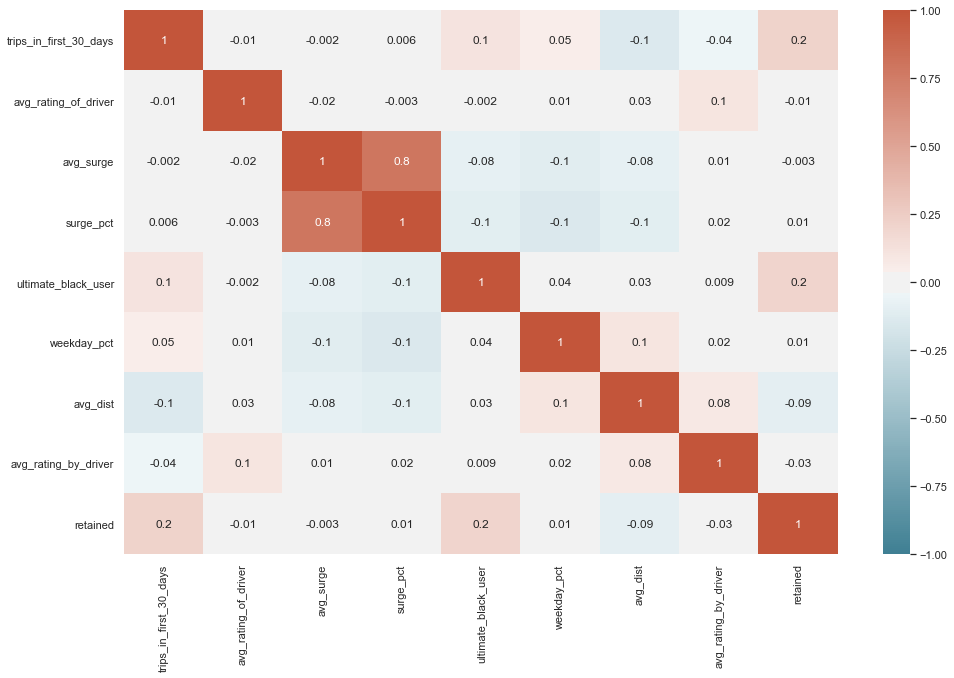

In [26]:
# correlation matrix 
corr = users_df.corr()
plt.figure(figsize = (16,10))
sns.heatmap(corr,fmt = '.01g',annot=True,vmin=-1, vmax=1,cmap=sns.diverging_palette(220,20,as_cmap=True))

Looking at the correlation matrix, it appears that the two most correlated variables are the avg_surge and surge_pct, which makes sense as they are related to each other. 

#### Pre-Processing

In [27]:
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier

Prior to putting the data into the model, we'll use one-hot encoding to change any categorical variables to numerical variables.

In [28]:
final = pd.get_dummies(users_df)
final.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,0,1,0,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,1,0,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,0,1,0,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0,0


17

Further we'll split our data into training and testing. 

In [163]:
X = final.drop(['retained','signup_date','last_trip_date','avg_surge'],axis=1)
y = final['retained']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=42)

#### Analysis & Machine Learning

In [164]:
# create first rfcl object
rfcl = RandomForestClassifier(n_estimators=100,max_depth = 10,random_state=42)

# Train the model on training data
rfcl.fit(X_train, y_train)

# predict price based on trained model
y_pred = rfcl.predict(X_test)

In [165]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7782666666666667


In [200]:
len(X_test)

15000

In [166]:
def feat_importance(rfcl,X_train):
    importance = rfcl.feature_importances_
    importance = pd.DataFrame(importance,index=X_train.columns,columns=["Importance"])
    return importance.sort_values(by=['Importance'],ascending=False)

# call function on new model and training data
importance = feat_importance(rfcl,X_train)
importance["Cumul_Imp"] = np.cumsum(importance.Importance)
importance[:15]

,Importance,Cumul_Imp
avg_rating_by_driver,0.213142,0.213142
surge_pct,0.148236,0.361378
weekday_pct,0.140944,0.502322
city_King's Landing,0.114975,0.617297
trips_in_first_30_days,0.067182,0.684479
avg_dist,0.063650,0.748129
phone_Android,0.057486,0.805615
ultimate_black_user,0.057158,0.862773
phone_iPhone,0.043104,0.905877
avg_rating_of_driver,0.035848,0.941724


In [182]:
feat_importance(rfcl,X_train).index

Index(['avg_rating_by_driver', 'surge_pct', 'weekday_pct',
       'city_King's Landing', 'trips_in_first_30_days', 'avg_dist',
       'phone_Android', 'ultimate_black_user', 'phone_iPhone',
       'avg_rating_of_driver', 'city_Astapor', 'city_Winterfell',
       'phone_Other'],
      dtype='object')

In [167]:
cf_threshold = .9
subset_x = importance.Importance[importance.Cumul_Imp <= cf_threshold].min()

In [168]:
# create list of important features 
important_features = list(importance[importance.Cumul_Imp <= cf_threshold].index)

# print count of important features
print("There are {} features that explain up to {}% of the model.".format(len(important_features),cf_threshold))

# get subset of training and testing data for new smaller set of features  
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

There are 8 features that explain up to 0.9% of the model.


In [169]:
#redo model with new features

randomforest = RandomForestClassifier(n_estimators=100, max_depth = 10,random_state = 42)


# train the model with shorter list of features
randomforest.fit(X_train_important, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [170]:
y_pred = randomforest.predict(X_test_important)

In [171]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7771333333333333


In [172]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred))

[[7992 1351]
 [1992 3665]]
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      9343
           1       0.73      0.65      0.69      5657

    accuracy                           0.78     15000
   macro avg       0.77      0.75      0.76     15000
weighted avg       0.77      0.78      0.77     15000



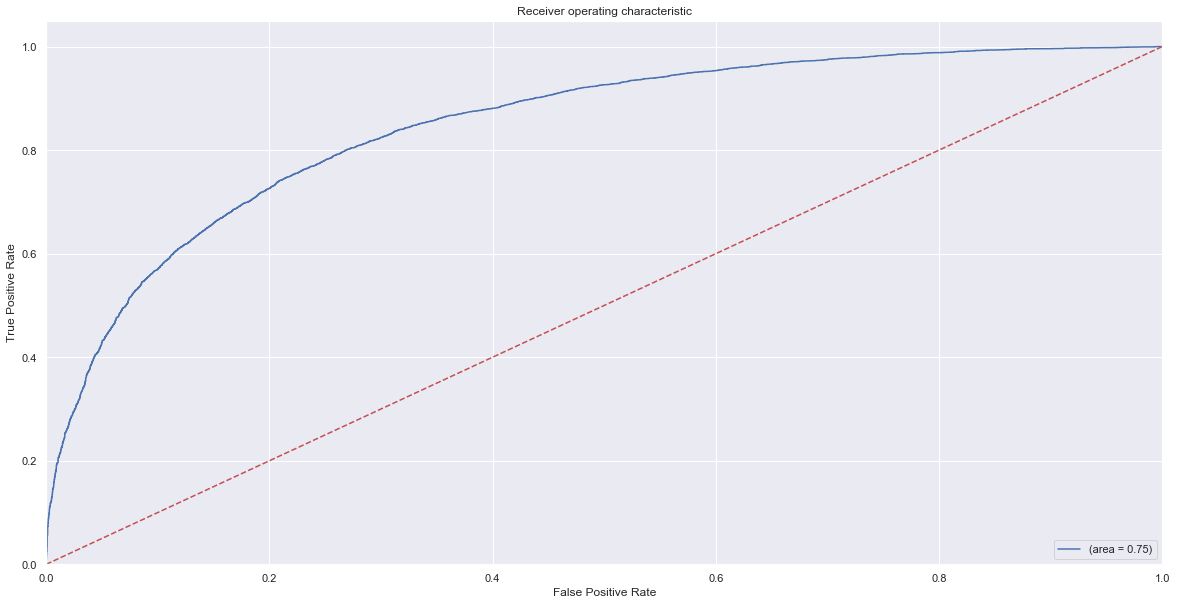

In [188]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, rfcl.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfcl.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='(area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()